In [ ]:
from zipfile import ZipFile
import os                                    # import necessary libraries and unzip zip file to load train and test 
os.chdir("/content/sample_data")
print(os.getcwd())
with ZipFile("image_data.zip", 'r') as zip:
    zip.extractall()


/content/sample_data


In [ ]:
import torch
from torchvision import transforms 
import numpy as np
import glob
import torch.nn as nn
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import pathlib
import matplotlib.pyplot as plt
import torch.nn.functional as F
import time
import os

In [ ]:
## transform images using pytorch packages       
# transform them by resizing image from 500*300 to 224 * 224 and normalize them
# Flip images to introduce variations 

transformer = transforms.Compose([transforms.Resize((224,224)),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

In [ ]:
train_folder_path = "/content/sample_data/train_data"
test_folder_path = "/content/sample_data/test_data"

# path to load data

In [ ]:
train_folder = torchvision.datasets.ImageFolder(train_folder_path,transform=transformer)
print(len(train_folder))
img_1,label = train_folder[0]           # Load images through imagefolder function and check dimensions
print(img_1.shape,label)



test_folder = torchvision.datasets.ImageFolder(test_folder_path,transform=transformer)
img_2,label = test_folder[2]           # Load images through imagefolder function and check dimensions
print(img_2.shape,label)   
print(train_folder.classes)                                    

900
torch.Size([3, 224, 224]) 0
torch.Size([3, 224, 224]) 0
['Benign', 'Malignant']


In [ ]:
img_2


tensor([[[ 0.4118,  0.0902,  0.0902,  ...,  0.1922,  0.1843,  0.4510],
         [-0.2627, -0.9373, -0.9137,  ..., -0.6392, -0.7020, -0.1529],
         [-0.2471, -0.9373, -0.9294,  ..., -0.6235, -0.6549, -0.0980],
         ...,
         [-0.0588, -0.6235, -0.5765,  ..., -0.2314, -0.2706,  0.1529],
         [-0.0980, -0.6392, -0.6000,  ..., -0.2549, -0.3020,  0.1216],
         [ 0.4510,  0.1922,  0.2549,  ...,  0.4118,  0.3882,  0.5922]],

        [[ 0.4196,  0.0980,  0.0902,  ...,  0.2157,  0.2078,  0.4824],
         [-0.2549, -0.9294, -0.9137,  ..., -0.6235, -0.6863, -0.1294],
         [-0.2471, -0.9373, -0.9294,  ..., -0.6078, -0.6392, -0.0745],
         ...,
         [-0.0588, -0.6235, -0.5765,  ..., -0.2392, -0.2706,  0.1529],
         [-0.0980, -0.6392, -0.6000,  ..., -0.2627, -0.3098,  0.1216],
         [ 0.4510,  0.1922,  0.2549,  ...,  0.4118,  0.3882,  0.5922]],

        [[ 0.3804,  0.0667,  0.0824,  ...,  0.2706,  0.2392,  0.4902],
         [-0.2863, -0.9529, -0.9294,  ..., -0

In [ ]:
#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')   # check if gpu is available
print(device)

cuda


In [ ]:
def assign_labels(folder):
    for img,label in folder:
        if label == 1:
            label = 0                    # assign class labels Benign = 0 and Malignant = 1 in both test and train data folders
        else:
            label = 1

assign_labels(train_folder)
assign_labels(test_folder)

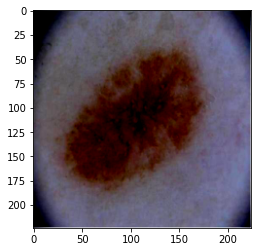

In [ ]:
plt.imshow(img_2.permute(1,2,0))

In [51]:
total = len(os.listdir( os.path.join(train_folder_path, "Benign"))) + len(os.listdir( os.path.join(train_folder_path, "Malignant")))
class_weights = [ total / len(os.listdir( os.path.join(train_folder_path, "Benign"))), total / len(os.listdir( os.path.join(train_folder_path, "Malignant")))]
val_size = int(0.2 * total);
train_size = total - val_size;

#train_data, val_data = random_split(train_folder, [train_size, val_size])
batch_size = 100
image_weights = [ class_weights[ x[1] ] for x in train_folder ]
sampling = WeightedRandomSampler(image_weights, len(train_folder))
#train_dataloader = DataLoader(train_folder, batch_size = batch_size , shuffle = True)
train_dataloader = DataLoader(train_folder, batch_size = batch_size , sampler=sampling)
#train_dataloader = DataLoader(train_data, batch_size = batch_size, sampler=sampling)
#val_dataloader = DataLoader(val_data, batch_size = batch_size, shuffle=True)
test_dataloader = DataLoader(test_folder, batch_size = batch_size , shuffle = True)

In [52]:
## define a sequential model 
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels= 3,out_channels= 8, kernel_size= 3 , stride= 1 ,padding = 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3 , stride =1 , padding = 1 )
        self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3 , stride =1 , padding = 1 )
        self.conv4 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3 , stride =1 , padding = 1 )
        self.conv5 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3 , stride =1 , padding = 1 )
        self.conv6 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3 , stride =1 , padding = 1 )






        self.fc1 = nn.Linear(256*28*28, 500)
        self.fc2 = nn.Linear(500, 100)
        self.fc3 = nn.Linear(100, 50)
        self.fc4 = nn.Linear(50, 2)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = self.pool(F.relu(self.conv3(x)))
        x = F.relu(self.conv4(x))
        x = self.pool(F.relu(self.conv5(x)))
        x = F.relu(self.conv6(x))


        x = x.view(-1, 256 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        x = self.fc4(x)
        return x


model = CNN().cuda()

In [53]:
losses = []
accuracies = []
epoches = 50
start = time.time()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
for epoch in range(epoches):
    epoch_loss = 0
    epoch_accuracy = 0
    for X, y in train_dataloader:
        X = X.cuda()
        y = y.cuda()
        preds = model(X)
        loss = loss_fn(preds, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        accuracy = ((preds.argmax(dim=1) == y).float().mean())
        epoch_accuracy += accuracy
        epoch_loss += loss
        print('.', end='', flush=True)
        
    epoch_accuracy = epoch_accuracy/len(train_dataloader)
    accuracies.append(epoch_accuracy)
    epoch_loss = epoch_loss / len(train_dataloader)
    losses.append(epoch_loss)
    print("Epoch: {}, train loss: {:.4f}, train accracy: {:.4f}, time: {}".format(epoch, epoch_loss, epoch_accuracy, time.time() - start))


.........Epoch: 0, train loss: 0.7494, train accracy: 0.5033, time: 4.959373235702515
.........Epoch: 1, train loss: 0.6939, train accracy: 0.4933, time: 10.110517978668213
.........Epoch: 2, train loss: 0.6926, train accracy: 0.5233, time: 15.271435260772705
.........Epoch: 3, train loss: 0.6937, train accracy: 0.4900, time: 20.395996570587158
.........Epoch: 4, train loss: 0.6802, train accracy: 0.5467, time: 25.58434510231018
.........Epoch: 5, train loss: 0.6832, train accracy: 0.5211, time: 30.751561164855957
.........Epoch: 6, train loss: 0.6541, train accracy: 0.5800, time: 35.985312700271606
.........Epoch: 7, train loss: 0.6791, train accracy: 0.5689, time: 41.15405774116516
.........Epoch: 8, train loss: 0.6553, train accracy: 0.5944, time: 46.47668814659119
.........Epoch: 9, train loss: 0.6393, train accracy: 0.6156, time: 51.778775453567505
.........Epoch: 10, train loss: 0.6878, train accracy: 0.5500, time: 57.12245988845825
.........Epoch: 11, train loss: 0.6735, train a

In [56]:
def test():
    # test phase
    model.eval()

    correct = 0
    total_benign = 304
    total_malignent = 75
    num_mal_pred = 0
    num_ben_pred = 0

    # We don't need gradients for test, so wrap in 
    # no_grad to save memory
    with torch.no_grad():
        for batch, target in test_dataloader:
            # Move the training batch to the GPU
            batch, target = batch.to(device), target.to(device)

            # forward propagation
            output = model( batch )
            #print(output.shape)
            # get prediction
            output = torch.argmax(output, 1)
            #print(output.shape)
            #print(target)
            # accumulate correct number
            correct += (output == target).sum().item()
            num_mal_pred += output.sum().item()
            num_ben_pred += len(output) - num_mal_pred
            #print()

    # Calculate test accuracy, specificity    
    acc = 100 * float(correct) / len(test_folder)
    print('Test accuracy: {}/{} ({:.2f}%)'.format( correct, len(test_folder), acc ) )
    print("True Negative Rate (Specificity): {}/{} = {:.2f}".format(num_ben_pred, total_benign, num_ben_pred/total_benign))
    print("True Positive Rate (Sensitivity): {}/{} = {:.2f}".format(num_mal_pred, total_malignent, num_mal_pred/total_malignent))
    print("Type I Error: {:.2f}".format(1 - (num_ben_pred/total_benign)))
    print("Type II Error: {:.2f}".format(1 - (num_mal_pred/total_malignent)))

    print(
        """
        TP = {0}     |     FP = {2}
        FN = {1}     |     TN = {3}
        """.format(num_mal_pred, total_malignent - num_mal_pred, total_benign - num_ben_pred, num_ben_pred)
        )
test()

Test accuracy: 275/379 (72.56%)
True Negative Rate (Specificity): 220/304 = 0.72
True Positive Rate (Sensitivity): 59/75 = 0.79
Type I Error: 0.28
Type II Error: 0.21

        TP = 59     |     FP = 84
        FN = 16     |     TN = 220
        
